In [2]:
"""
# Project 1: Sutton - Kevin McCarville
"""
import numpy as np
import random 
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
# create state transitions matrix
# will use this later for random walks
trans = {'B':['A', 'C'],
        'C':['B', 'D'],
        'D':['C', 'E'],
        'E':['D', 'F'],
        'F':['E', 'G']}

In [4]:
# here we convert the state of the MDP into a numerical vector
# dont need it for A or G as they are terminal states and the seuqence ends
vecs = {'B' : np.array([1,0,0,0,0]),
        'C' : np.array([0,1,0,0,0]),
        'D' : np.array([0,0,1,0,0]),
        'E' : np.array([0,0,0,1,0]),
        'F' : np.array([0,0,0,0,1])}

In [56]:
# create an individual path

def create_path():
    # we start in state D
    # initializations
    initial_state = 'D'
    path = [initial_state]
    vector_path = [vecs[initial_state]]
    current_state = initial_state
    final_reward = 0
    
    # keep going until we hit a terminal state
    while current_state not in ['A', 'G']:
        # go to random neighbor
        neighbors = trans[current_state]
        next_state = np.random.choice(neighbors)
        path.append(next_state)
        
        # not terminal
        if next_state not in ['A', 'G']:
            vector_path.append(vecs[next_state])
        # terminal - we lost
        elif next_state == 'A':
            final_reward = 0
        # terminal - we won
        elif next_state == 'G':
            final_reward = 1
        
        # update current state
        current_state = next_state
    return path, vector_path, final_reward

# Execute the function
path, vector_path, final_reward = create_path()
print(path)
print(vector_path)
print(final_reward)

['D', 'E', 'D', 'E', 'D', 'C', 'D', 'E', 'F', 'E', 'D', 'C', 'B', 'A']
[array([0, 0, 1, 0, 0]), array([0, 0, 0, 1, 0]), array([0, 0, 1, 0, 0]), array([0, 0, 0, 1, 0]), array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([0, 0, 1, 0, 0]), array([0, 0, 0, 1, 0]), array([0, 0, 0, 0, 1]), array([0, 0, 0, 1, 0]), array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])]
0


In [6]:
# generate a set of sequences

def create_training_sets(num_sets, num_sequences):
    all_training_sets = []
    all_reward_sets = []
    
    # loop for each training set
    # sets = range(num_sets)
    num_sets = int(num_sets)
    num_sequences = int(num_sequences)
    # for each desired set
    for set in range(num_sets):
        sequences_set = []
        rewards_set = []
        
        # loop for each sequence
        for _ in range(num_sequences):
            # create an individual path
            _, vector_sequence, reward = create_path()
            # add it to the sequence set
            sequences_set.append(vector_sequence)
            # add its rewards as well
            rewards_set.append(reward)
        # add the sets to the master list
        all_training_sets.append(sequences_set)
        all_reward_sets.append(rewards_set)
    return all_training_sets, all_reward_sets

# Execute the function
training_sets, reward_sets = create_training_sets(3, 2)
print(training_sets)
print(reward_sets)

[[[array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])], [array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])]], [[array([0, 0, 1, 0, 0]), array([0, 0, 0, 1, 0]), array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])], [array([0, 0, 1, 0, 0]), array([0, 0, 0, 1, 0]), array([0, 0, 0, 0, 1]), array([0, 0, 0, 1, 0]), array([0, 0, 0, 0, 1])]], [[array([0, 0, 1, 0, 0]), array([0, 0, 0, 1, 0]), array([0, 0, 0, 0, 1]), array([0, 0, 0, 1, 0]), array([0, 0, 0, 0, 1])], [array([0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0]), array([0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0])]]]
[[0, 0], [0, 1], [1, 0]]


In [49]:
# perform temporal difference learning

def temporal_difference_training(sequences, rewards, lambda_val, learning_rate=0.001, tolerance=0.1):
    # initialize weights
    weights = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    
    # run until tolerance is reached
    while True:
        # copy weights to check for convergence
        old_weights = weights.copy()
        
        for seq_index in range(len(sequences)):
            # initialize error accumulator and weight update
            error_acc = np.array([0, 0, 0, 0, 0], dtype=np.float64)
            weight_upd = np.array([0, 0, 0, 0, 0], dtype=np.float64)
            sequence = sequences[seq_index]
            reward = rewards[seq_index]
            
            # loop through each state in the sequence
            for t in range(len(sequence)):
                current_state = sequence[t]
                # calculate the prediction for the current state based off current weights
                current_prediction = np.dot(weights, current_state)
                
                # if not terminal state, calculate the next prediction and update the weights
                if t != len(sequence) - 1:
                    # get the next state in this generated sequence and the next prediction
                    next_state = sequence[t + 1]
                    next_prediction = np.dot(weights, next_state)
                    # get the prediction error and update the weights
                    error_acc = lambda_val * error_acc + current_state
                    # keep learning rate low
                    weight_upd += learning_rate * (next_prediction - current_prediction) * error_acc
                else:
                    # if terminal state, update the weights based off the reward
                    error_acc = lambda_val * error_acc + current_state
                    weight_upd += learning_rate * (reward - current_prediction) * error_acc
                
            weights += weight_upd

            # debugging
            # if sum(weights) > 20:
            #     print("here", weights)
            #     print("here", weight_upd)
            #     print("current prediction", current_prediction)
            #     print("next prediction", next_prediction)
            #     print("error_acc", error_acc)
            #     print(reward)
            #     break
            
        # check for convergence
        weight_change = np.linalg.norm(old_weights - weights)
        if weight_change <= tolerance:
            break
    return weights

# Example usage:
# training_sets, reward_sets = create_training_sets(3, 10)
# trained_weights = temporal_difference_training(training_sets[0], reward_sets[0], 0.3)
# print(trained_weights)

In [50]:
# calculate the average error for a set of training sets

def td_training_error(training_sets, reward_sets, lambda_val, true_weights, learning_rate=0.001, tolerance=0.001):
    # intialize vars
    total_sets = len(training_sets)
    cumulative_error = 0
    
    # loop through each training set
    for set_index in range(total_sets):
        # get the sequences and rewards
        sequences = training_sets[set_index]
        rewards = reward_sets[set_index]
        # get the estimated weights
        estimated_weights = temporal_difference_training(sequences, rewards, lambda_val, learning_rate, tolerance)
        # calc cum error
        cumulative_error += np.sqrt(np.mean((true_weights - estimated_weights)**2))
    average_error = cumulative_error / total_sets
    return average_error

# Example usage:
# training_sets, reward_sets = create_training_sets(3, 10)
# avg_error = td_training_error(training_sets, reward_sets, 0.3, np.array([0.5, 0.5, 0.5, 0.5, 0.5]))
# print(avg_error)


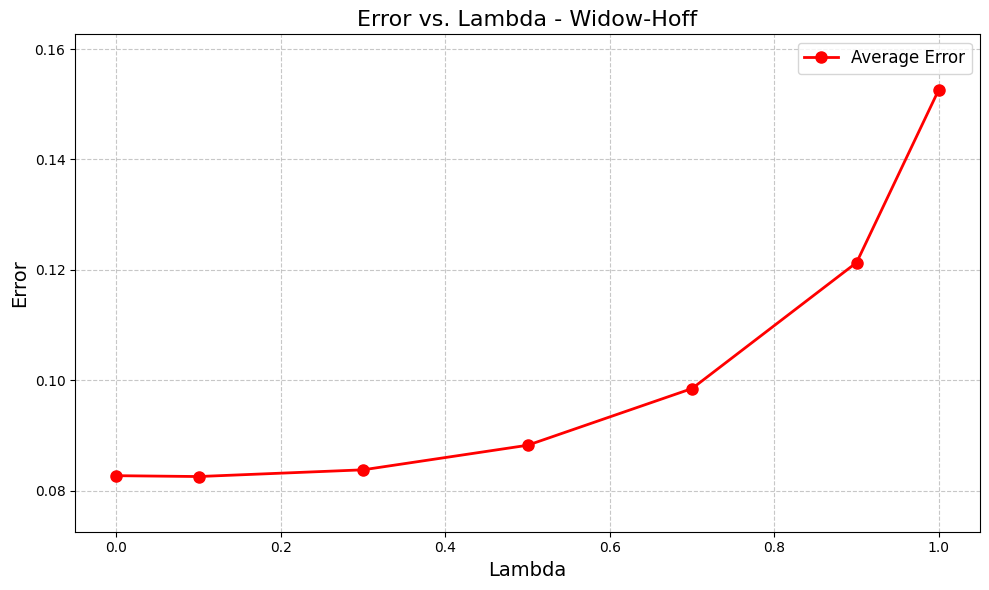

In [51]:
# fig 3

def fig3(lambda_values, true_weights, num_training_sets=100, num_sequences=10):
    # reproducing figure 3 from the paper
    average_errors = []
    # Generate the training and reward sets only once for consistency
    training_sets, reward_sets = create_training_sets(num_training_sets, num_sequences)
    
    # for each lambda value, calculate the average error
    for lambda_val in lambda_values:
        average_error = td_training_error(training_sets, reward_sets, lambda_val, true_weights)
        average_errors.append(average_error)
    
    # Customize plot appearance
    plt.figure(figsize=(10, 6))
    plt.plot(lambda_values, average_errors, marker='o', linestyle='-', color='r', markersize=8, linewidth=2, label='Average Error')
    plt.xlabel('Lambda', fontsize=14)
    plt.ylabel('Error', fontsize=14)
    plt.title('Error vs. Lambda - Widow-Hoff', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim((min(lambda_values) - 0.05, max(lambda_values) + 0.05))
    plt.ylim((min(average_errors) - 0.01, max(average_errors) + 0.01))
    plt.margins(x=0.5, y=0.15)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('figure3.png', dpi=300)
    plt.show()

# Example usage:
lambda_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
# true weights given in the paper
true_weights = np.array([0.1666, 0.3333, 0.5, 0.6666, 0.8333])
fig3(lambda_values, true_weights)

In [10]:
# update the weights each step not each sequence - need this for fig 4 and 5

def td_training_upd_each_seq(sequences, rewards, lambda_val, learning_rate=0.01):
    weights = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
    
    for i in range(len(sequences)):
        # initialize error and weight update
        error = np.array([0,0,0,0,0], dtype = np.float16)
        weight_upd = np.array([0,0,0,0,0], dtype = np.float16)
        seqs = sequences[i]
        rew = rewards[i]

        # go through each step in the sequence
        for step in range(len(seqs)):
            if step != len(seqs) - 1:
                # not terminal
                # get the current state and prediction
                current_state = seqs[step]
                current_pred = np.dot(weights, current_state)
                # get the next state and prediction
                next_state = seqs[step+1] 
                next_pred = np.dot(weights, next_state)
                # update the error and weights
                error = lambda_val * error + current_state
                weight_upd = weight_upd + learning_rate * (next_pred - current_pred) * error
            else:
                # terminal state
                current_state = seqs[step]
                current_pred = np.dot(weights, current_state)
                #next state is the terminal state, A or G, but we know the next pred from the rewards
                error =  lambda_val * error + current_state
                weight_upd = weight_upd + learning_rate * (rew - current_pred) * error
            # NOTE: the weights are updated after each step, not each sequence
        weights = weights + weight_upd
    
    return weights


# Example usage:
training_sets, reward_sets = create_training_sets(3, 10)
new_weights = td_training_upd_each_seq(training_sets[0], reward_sets[0], 0.3)
print(new_weights)

[0.47065498 0.49068879 0.49865161 0.5059207  0.52029646]


In [11]:
# calculate the average error for a set of training sets - updating for each step

def td_training_upd_each_seq_error(training_sets, reward_sets, lambda_val, true_weights, learning_rate=0.01):
    # intialize vars
    num_training_sets = len(training_sets)
    err = 0
    # loop through each training set
    for i in range(num_training_sets):
        training_seqs = training_sets[i]
        reward_seqs = reward_sets[i]
        # get the estimated weights
        w_td = td_training_upd_each_seq(training_seqs, reward_seqs, lambda_val, learning_rate)
        # calculate the error
        err += np.sqrt(np.mean((true_weights - w_td)**2))
    # calculate the average error
    avg_err = err / num_training_sets
    return avg_err

finished lambda:  0.0 alpha:  0.0 error:  0.23570226039551628
finished lambda:  0.0 alpha:  0.05 error:  0.17481890226463
finished lambda:  0.0 alpha:  0.1 error:  0.1304217290575284
finished lambda:  0.0 alpha:  0.15000000000000002 error:  0.10176460701857526
finished lambda:  0.0 alpha:  0.2 error:  0.08863951057467281
finished lambda:  0.0 alpha:  0.25 error:  0.09084491111366186
finished lambda:  0.0 alpha:  0.30000000000000004 error:  0.11059154464239103
finished lambda:  0.0 alpha:  0.35000000000000003 error:  0.1698989820566048
finished lambda:  0.0 alpha:  0.4 error:  0.35005022620341153
finished lambda:  0.0 alpha:  0.45 error:  0.8446579965895346
finished lambda:  0.0 alpha:  0.5 error:  2.1300092531216963
finished lambda:  0.0 alpha:  0.55 error:  5.637871036980206
finished lambda:  0.0 alpha:  0.6000000000000001 error:  14.090873774272252
finished lambda:  0.3 alpha:  0.0 error:  0.23570226039551628
finished lambda:  0.3 alpha:  0.05 error:  0.16569107770635405
finished lam

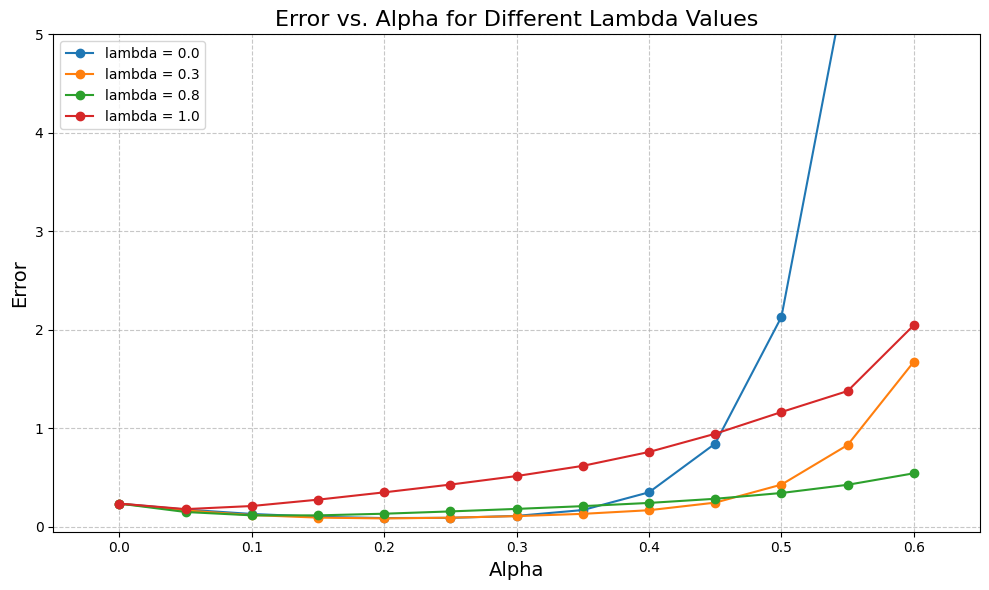

In [57]:
# Now we repeat but edit alpha

def plot_error_for_lambda_and_alpha(lambda_vals, alpha_vals, true_weights, num_sets=100, num_sequences=10):
    # intialize vars
    error_map = {}
    training_sets, reward_sets = create_training_sets(num_sets, num_sequences)

    # go through each lambda value
    for lambda_val in lambda_vals:
        errors_for_alpha = []
        # go through each alpha value
        for alpha_val in alpha_vals:
            # print(len(training_sets))
            # print(len(reward_sets))    
            # get the average error for the training sets for this alpha lambda pair
            avg_error = td_training_upd_each_seq_error(training_sets, reward_sets, lambda_val, true_weights, alpha_val)
            print("finished lambda: ", lambda_val, "alpha: ", alpha_val, "error: ", avg_error)
            # add the error to the list
            errors_for_alpha.append(avg_error)
        error_map[lambda_val] = errors_for_alpha

    # # Define the color map
    # colors = ['#000066', '#003399', '#0066cc', '#6699ff']

    # plt.figure(figsize=(10, 6))
    # # Plot for each lambda
    # for idx, lambda_val in enumerate(lambda_vals):
    #     plt.plot(alpha_vals, error_map[lambda_val], marker='o', label=f'lambda = {lambda_val}', color=colors[idx % len(colors)])

    # Plot figure 4 
    plt.figure(figsize=(10, 6))
    # plot for each lambda
    for lambda_val in lambda_vals:
        plt.plot(alpha_vals, error_map[lambda_val], marker='o', label=f'lambda = {lambda_val}')
    
    plt.legend()
    plt.margins(x=0.5, y=0.15)
    plt.xlim((min(alpha_vals) - 0.05, max(alpha_vals) + 0.05))
    plt.ylim((-0.05, 5))
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Error', fontsize=14)
    plt.title('Error vs. Alpha for Different Lambda Values', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('figure4.png', dpi=300)
    plt.show()
    return error_map


# Example usage:
lambda_vals = np.array([0, 0.3, 0.8, 1])
alpha_vals = np.array([0.05 * i for i in range(13)])
true_weights = np.array([1, 2, 3, 4, 5]) / 6
error_map = plot_error_for_lambda_and_alpha(lambda_vals, alpha_vals, true_weights)

finished lambda:  0.0 alpha:  0.0 error:  0.23570226039551628
finished lambda:  0.0 alpha:  0.05 error:  0.17483174892728254
finished lambda:  0.0 alpha:  0.1 error:  0.1306138404793693
finished lambda:  0.0 alpha:  0.15000000000000002 error:  0.10221042465958009
finished lambda:  0.0 alpha:  0.2 error:  0.09030036062851257
finished lambda:  0.0 alpha:  0.25 error:  0.09769236363170983
finished lambda:  0.0 alpha:  0.30000000000000004 error:  0.12429204426326644
finished lambda:  0.0 alpha:  0.35000000000000003 error:  0.17100652087310422
finished lambda:  0.0 alpha:  0.4 error:  0.25032430513125625
finished lambda:  0.0 alpha:  0.45 error:  0.40202623777741364
finished lambda:  0.0 alpha:  0.5 error:  0.7259227964187399
finished lambda:  0.0 alpha:  0.55 error:  1.4319307110944248
finished lambda:  0.0 alpha:  0.6000000000000001 error:  2.9483095996078417
finished lambda:  0.1 alpha:  0.0 error:  0.23570226039551628
finished lambda:  0.1 alpha:  0.05 error:  0.17196127886042262
finish

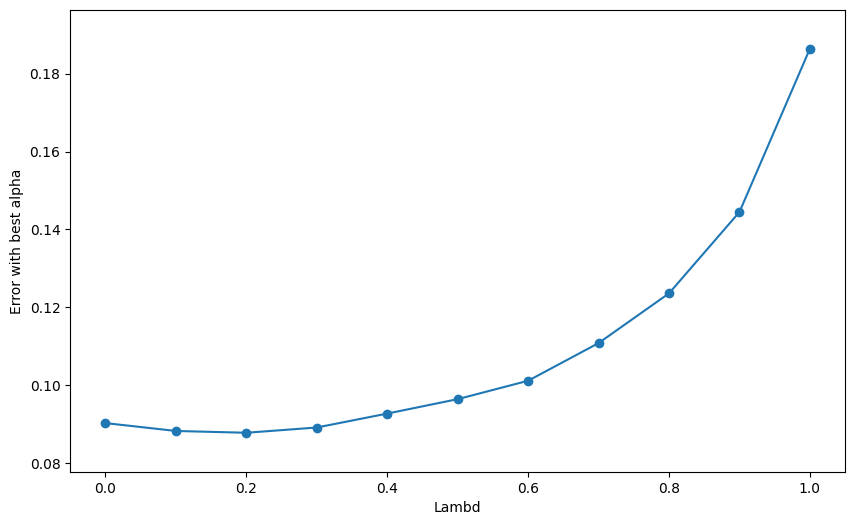

In [55]:
# Figure 5

def fig5(lambda_vals, alpha_vals, true_weights, num_sets=100, num_sequences=10):
    #avg_err_lambd_alpha = {}
    # initialize vars
    lam_alpha = {}
    avg_err_lambd_bestalpha = []
    train_sets, r_sets = create_training_sets(num_sets, num_sequences)
    
    # go through each lambda value
    for lam in lambda_vals:
        min_err = 1000000
        best_alpha = 0
        # go through each alpha value
        for alpha in alpha_vals:
            # get the average error for the training sets for this alpha lambda pair
            avg_err = td_training_upd_each_seq_error(train_sets, r_sets, lam, true_weights, alpha)
            print("finished lambda: ", lam, "alpha: ", alpha, "error: ", avg_err)
            # find the best alpha for this lambda
            if avg_err < min_err:
                best_alpha = alpha
                min_err = avg_err
        lam_alpha[lam] = best_alpha
        # store the error for the best alpha
        avg_err_lambd_bestalpha.append(min_err)
    
    # print the best alpha for each lambda
    for key in lam_alpha:
        print("lambda" , key, "alpha", round(lam_alpha[key], 4))
    print(lam_alpha)
    # plot the figure
    plt.figure(figsize=(10, 6))
    plt.plot(lambd_values, avg_err_lambd_bestalpha, marker = 'o')
    plt.margins(x = 0.5, y = 0.15)
    plt.xlim((min(lambd_values) - 0.05, max(lambd_values) + 0.05))
    plt.ylim((min(avg_err_lambd_bestalpha) - 0.01, max(avg_err_lambd_bestalpha) + 0.01))
    plt.xlabel('Lambd')
    plt.ylabel('Error with best alpha')
    plt.savefig('figure5')
    plt.show()
    
lambd_values = [i/10 for i in range(11)]
alpha_values = [0.05*i for i in range(13)]
w_true = np.array([1,2,3,4,5])/6
fig5(lambd_values, alpha_values, w_true, 100, 10)